$$\Huge \text{RAPORT}$$
$$\huge \text{LISTA 3}$$
$$\large \text{Autorzy: Katarzyna Rudzińska, Jagoda Płócienniczak}$$

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from statsmodels.formula.api import glm
import statsmodels.api as sm
from scipy.stats import binomtest, chi2, norm, combine_pvalues
from statsmodels.stats.proportion import proportions_ztest
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.eval_measures import bic

Analiza składa się z pięciu głównych części, z których niektóre odwołują się do wcześniej wprowadzonych pojęć i zmiennych z poprzedniego raportu. Aby zachować spójność oraz umożliwić pełne zrozumienie, ich implementacja została powtórzona również w tym opracowaniu. W ten sposób raport pozostaje spójny i czytelny.

In [2]:
data = pd.read_csv('ankieta.csv', encoding='Windows-1250', sep=';')
data['DZIAŁ'] = data['DZIAŁ'].astype("category")
data['CZY_KIER'] = data['CZY_KIER'].astype("category")
data['PŁEĆ'] = data['PŁEĆ'].astype("category")

In [3]:
def is_satisfied(satisfaction_lvl):
    if satisfaction_lvl == -2 or satisfaction_lvl == -1:
        return 'NIE'
    else:
        return 'TAK'

data["CZY_ZADOW"] = data["PYT_2"].apply(is_satisfied)
data["CZY_ZADOW"] = data["CZY_ZADOW"].astype("category")

In [4]:
data["CZY_ZADOW_2"] = data["PYT_3"].apply(is_satisfied)
data["CZY_ZADOW_2"] = data["CZY_ZADOW_2"].astype("category")

czy_zadow = data["CZY_ZADOW"].apply(lambda x: 1 if x == "TAK" else 0).astype(int)
czy_zadow_2 = data["CZY_ZADOW_2"].apply(lambda x: 1 if x == "TAK" else 0).astype(int)

## CZĘŚĆ I i II

### ZADANIE 1
    Napisz funkcję, która zwraca p-wartość w omówionym na wykładzie warunkowym teście symetrii w przypadku tabeli 2×2.

In [ ]:
def warunkowy_test_symetrii(b, c):
    """
    Warunkowy test symetrii dla tabeli 2x2 oparty na rozkładzie dwumianowym B(n*, 1/2)

    Parametry:
    b -- liczba przypadków A=1, B=2 (Y_12)
    c -- liczba przypadków A=2, B=1 (Y_21)

    Zwraca:
    p-wartość testu
    """
    n_star = b + c
    if n_star == 0:
        return 1.0  
    wynik = binomtest(b, n=n_star, p=0.5, alternative='two-sided')
    return wynik.pvalue

Funkcja _warunkowy_test_symetrii(b, c)_ implementuje dokładny test warunkowy służący do sprawdzania **symetrii** w tabeli 2×2, czyli testowania hipotezy:

$
H_0 : p_{12} = p_{21}
$

Dla tabeli:

|       | B=1       | B=2       |
|-------|-----------|-----------|
| A=1   | $ Y_{11} $ | $ Y_{12} $ |
| A=2   | $ Y_{21} $ | $ Y_{22} $ |

test koncentruje się na wartościach poza przekątną:  
$ Y_{12} = b $, $ Y_{21} = c $

Zakładając hipotezę zerową $ H_0 $, statystyka $ Y_{12} $ warunkowana sumą $ Y_{12} + Y_{21} = n^* $ ma rozkład:

$
Y_{12} \mid (Y_{12} + Y_{21} = n^*) \sim \text{B}(n^*, 0.5)
$

gdzie:
- $ n^* = b + c $ — łączna liczba przypadków niesymetrycznych,
- $ \text{B}(n^*, 0.5) $ — rozkład dwumianowy z parametrem sukcesu \( p = 0.5 \)

Funkcja zwraca dokładną **p-wartość** testu dwustronnego na podstawie tego rozkładu. Jest to test **dokładny**, zalecany przy małych licznościach.


In [155]:
p = warunkowy_test_symetrii(b=3, c=7)
print("P-wartość:", p)

P-wartość: 0.34375


### ZADANIE 2
    W tabeli 1 umieszczono dane dotyczące reakcji na lek po godzinie od jego przyjęcia dla dwóch różnych leków przeciwbólowych stosowanych w migrenie. Leki zostały zaaplikowane grupie pacjentów w dwóch różnych atakach bólowych. Na podstawie danych zweryfikuj hipotezę, że leki te są jednakowo skuteczne korzystając z testu:

        a) McNemara z poprawką na ciągłość,
        b) warunkowego (korzystając z funkcji zadeklarowanej w zadaniu 1.) 

<div align="center">

<table>
  <thead>
    <tr>
      <th rowspan="2">Reakcja na lek A</th>
      <th colspan="2">Reakcja na lek B</th>
    </tr>
    <tr>
      <th>Negatywna</th>
      <th>Pozytywna</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><strong>Negatywna</strong></td>
      <td>1</td>
      <td>5</td>
    </tr>
    <tr>
      <td><strong>Pozytywna</strong></td>
      <td>2</td>
      <td>4</td>
    </tr>
  </tbody>
</table>

<br>
Table 1: Dane do zadania 2.


Na podstawie danych zawartych w **Tabeli 1**, testujemy hipotezę:

$
H_0: \text{Skuteczność leku A i leku B jest taka sama}
$

Dane przedstawiają sparowaną tablicę 2×2:

|                        | Lek B: Negatywna | Lek B: Pozytywna |
|------------------------|------------------|------------------|
| **Lek A: Negatywna**   | $ a = 1 $       | $ b = 5 $      |
| **Lek A: Pozytywna**   | $ c = 2 $       | $ d = 4 $       |

Zatem mamy:
- $ b = 5 $: A negatywna, B pozytywna  
- $ c = 2 $: A pozytywna, B negatywna

#### a) Test McNemara z poprawką na ciągłość

Test McNemara dla tabeli 2×2 z poprawką na ciągłość obliczany jest ze wzoru:

$
\chi^2 = \dfrac{(|b - c| - 1)^2}{b + c}
$

Wartość statystyki testowej porównujemy z rozkładem chi-kwadrat z 1 stopniem swobody.

In [156]:
b = 5
c = 2

chi2_stat = ((abs(b - c) - 1) ** 2) / (b + c)
p_mcnemar = 1 - chi2.cdf(chi2_stat, df=1)

print("Test McNemara:")
print("Statystyka chi^2:", chi2_stat)
print("P-wartość:", p_mcnemar)

Test McNemara:
Statystyka chi^2: 0.5714285714285714
P-wartość: 0.4496917979688908


#### b) Warunkowy test symetrii 

In [157]:
p_warunkowy = warunkowy_test_symetrii(b=5, c=2)

print("Warunkowy test symetrii:")
print("P-wartość:", p_warunkowy)

Warunkowy test symetrii:
P-wartość: 0.453125


W przypadku obu testów p-wartość jest **większa niż 0.05**, co oznacza, że **nie ma podstaw do odrzucenia hipotezy zerowej**. Nie zaobserwowano statystycznie istotnych różnic między skutecznością leków A i B. Oznacza to, że na podstawie dostępnych danych **nie możemy stwierdzić, że jeden lek działa lepiej od drugiego**.

### ZADANIE 3
    Przeprowadź symulacje w celu porównania mocy testu Z i testu Z0 przedstawionych na wykładzie. Rozważ różne długości prób.

Celem symulacji jest porównanie **mocy** dwóch testów statystycznych służących do porównania dwóch proporcji.

Statystyka testowa

Dla obu testów analizujemy różnicę pomiędzy proporcjami:
$
D = \hat{p}_{1+} - \hat{p}_{+1} = \dfrac{Y_{12}}{n} - \dfrac{Y_{21}}{n}
$

#### Test $Z$:

Statystyka testowa:
$
Z = \dfrac{D}{\sqrt{\hat{\sigma}^2(D)}}
$

gdzie:
$
\hat{\sigma}^2(D) = \dfrac{\hat{p}_{1+}(1 - \hat{p}_{1+}) +\hat{p}_{+1}(1 - \hat{p}_{+1}) -2((\hat{p}_{11} \hat{p}_{22})-(\hat{p}_{12} \hat{p}_{21}))}{n}
$

In [10]:
def test_Z(array_2x2, n):
    Y_1_1 = array_2x2[0][0]
    Y_1_2 = array_2x2[0][1]
    Y_2_1 = array_2x2[1][0]
    Y_2_2 = array_2x2[1][1]

    y11, y12, y21, y22 = Y_1_1, Y_1_2, Y_2_1, Y_2_2

    p11 = y11 / n
    p12 = y12 / n
    p21 = y21 / n
    p22 = y22 / n

    p1_plus = (y11 + y12) / n
    p_plus1 = (y11 + y21) / n

    D = p12 - p21

    var = (p1_plus * (1 - p1_plus) + p_plus1 * (1 - p_plus1) - 2 * (p11 * p22 - p12 * p21)) / n

    if var <= 0:
        return 1.0

    Z = D / np.sqrt(var)
    p_value = 2 * (1 - norm.cdf(abs(Z)))
    return p_value

#### Test $Z_0$:

Statystyka testowa:
$
Z_0 = \dfrac{D}{\sqrt{\sigma_0^2}}, \quad \text{gdzie} \quad
\sigma_0^2 = \dfrac{Y_{12} + Y_{21}}{n^2}
$

In [17]:
def test_Z0(array_2x2, n):
    Y_1_1 = array_2x2[0][0]
    Y_1_2 = array_2x2[0][1]
    Y_2_1 = array_2x2[1][0]
    Y_2_2 = array_2x2[1][1]

    y12 = Y_1_2
    y21 = Y_2_1

    D = (y12 - y21) / n
    var0 = (y12 + y21) / (n ** 2)

    if var0 <= 0:
        return 1.0

    Z0 = D / np.sqrt(var0)
    p_value = 2 * (1 - norm.cdf(abs(Z0)))
    return p_value

W przeprowadzonej symulacji porównano moc testów $Z$ i $Z_0$ dla różnych wielkości prób (n = 10, 20, 50, 100, 200) oraz różnic pomiędzy prawdopodobieństwami przejść niesymetrycznych $p_{12}$ i $p_{21}$, określonych jako $\Delta = p_{12} - p_{21} = 0.0, 0.1, 0.2, 0.3$. 

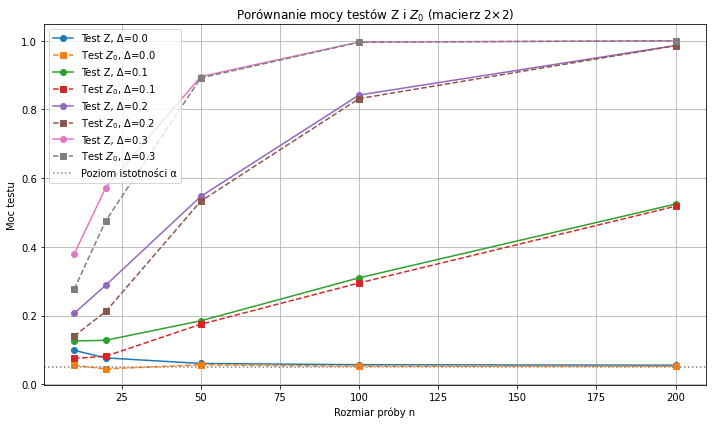

In [18]:
n_values = [10, 20, 50, 100, 200]
delta_values = [0.0, 0.1, 0.2, 0.3]
alpha = 0.05
n_sim = 5000

results_Z = {}
results_Z0 = {}

for delta in delta_values:
    power_Z = []
    power_Z0 = []

    p12 = 0.25 + delta / 2
    p21 = 0.25 - delta / 2
    p11 = p22 = (1 - p12 - p21) / 2
    probs = [p11, p12, p21, p22]  

    for n in n_values:
        reject_Z = 0
        reject_Z0 = 0

        for _ in range(n_sim):
            y_sample = np.random.multinomial(n, probs)
            array_2x2 = [[y_sample[0], y_sample[1]], [y_sample[2], y_sample[3]]]

            if test_Z(array_2x2, n) < alpha:
                reject_Z += 1
            if test_Z0(array_2x2, n) < alpha:
                reject_Z0 += 1

        power_Z.append(reject_Z / n_sim)
        power_Z0.append(reject_Z0 / n_sim)

    results_Z[delta] = power_Z
    results_Z0[delta] = power_Z0

plt.figure(figsize=(10, 6))
for delta in delta_values:
    plt.plot(n_values, results_Z[delta], marker='o', label=f"Test Z, Δ={delta}")
    plt.plot(n_values, results_Z0[delta], marker='s', linestyle='--', label=f"Test $Z_0$, Δ={delta}")

plt.axhline(alpha, color='gray', linestyle=':', label="Poziom istotności α")
plt.title("Porównanie mocy testów Z i $Z_0$ (macierz 2×2)")
plt.xlabel("Rozmiar próby n")
plt.ylabel("Moc testu")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Wykres porównuje moc testów Z i $Z_0$ dla różnych efektów $\Delta$ i liczebności próby. Dla $\Delta$ > 0 test $Z_0$ wykazuje wyraźnie większą moc, lekko bardziej widoczne przy większych próbach, co oznacza jego większą skuteczność w wykrywaniu rzeczywistych efektów.


### ZADANIE 4
    Dla danych dołączonych do pierwszej listy zadań, na podstawie zmiennych CZY_ZADW oraz CZY_ZADW_2, zweryfikuj hipotezę, że zadowolenie ze szkoleń w pierwszym badanym okresie i w drugim badanym okresie pierwszego badania odpowiada modelowi symetrii. Czy na podstawie uzyskanych wników możemy wnioskować, że poziom zadowolenia ze szkoleń nie uległ zmianie? Przyjmij poziom istotności 0.05.

In [161]:
table = pd.crosstab(data["CZY_ZADOW"], data["CZY_ZADOW_2"])

b = table.loc['TAK', 'NIE'] if ('TAK' in table.index and 'NIE' in table.columns) else 0
c = table.loc['NIE', 'TAK'] if ('NIE' in table.index and 'TAK' in table.columns) else 0

chi2_stat = ((abs(b - c) - 1) ** 2) / (b + c)
p_mcnemar = 1 - chi2.cdf(chi2_stat, df=1)

print("Test McNemara:")
print("P-wartość:", p_mcnemar)

Test McNemara:
P-wartość: 0.03763531378731433


Na podstawie przeprowadzonego testu McNemara uzyskano wartość $ p = 0.0376 $, która jest mniejsza niż przyjęty poziom istotności $\alpha = 0.05$. Oznacza to, że istnieją statystycznie istotne różnice między poziomem zadowolenia ze szkoleń w pierwszym i drugim badanym okresie. Odrzucamy hipotezę symetrii – poziom zadowolenia ze szkoleń uległ zmianie między badanymi okresami.

### ZADANIE 5
    W firmie, o której mowa w zadaniu 1 z listy 1, wdrożono pewne działania w celu poprawy komfortu pracy. Następnie badaną grupę respondentów ponownie poproszono o odpowiedź na pytanie dotyczące oceny podejścia firmy do umożliwiania wdrażania wiedzy zdobytej na szkoleniach. W Tabeli 2 przedstawiono tablicę dwudzielczą uwzględniającą odpowiedzi na pytanie w obu tych okresach. Na podstawie danych zweryfikuj hipotezę, że odpowiedzi w pierwszym badanym okresie i w drugim okresie odpowiadają modelowi symetrii. Na podstawie wyników uzyskanych przy weryfikacji hipotezy dotyczącej symetrii, sformułuj wniosek dotyczący hipotezy, że ocena podejścia firmy nie uległa zmianie.

<div align="center">

<table>
  <thead>
    <tr>
      <th rowspan="2">Pytanie 1</th>
      <th colspan="5">Pytanie 2</th>
    </tr>
    <tr>
      <th>-2</th>
      <th>-1</th>
      <th>0</th>
      <th>1</th>
      <th>2</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><strong>-2</strong></td>
      <td>10</td>
      <td>2</td>
      <td>1</td>
      <td>1</td>
      <td>0</td>
    </tr>
    <tr>
      <td><strong>-1</strong></td>
      <td>0</td>
      <td>15</td>
      <td>1</td>
      <td>1</td>
      <td>0</td>
    </tr>
    <tr>
      <td><strong>0</strong></td>
      <td>1</td>
      <td>1</td>
      <td>32</td>
      <td>6</td>
      <td>0</td>
    </tr>
    <tr>
      <td><strong>1</strong></td>
      <td>0</td>
      <td>0</td>
      <td>1</td>
      <td>96</td>
      <td>3</td>
    </tr>
    <tr>
      <td><strong>2</strong></td>
      <td>1</td>
      <td>1</td>
      <td>0</td>
      <td>1</td>
      <td>26</td>
    </tr>
  </tbody>
</table>

<br>
Table 1: Dane do zadania 5.

Do oceny, czy rozkład odpowiedzi w dwóch różnych okresach badania jest symetryczny, wykorzystano **test ilorazu wiarygodności (G-test)**.

In [162]:
def likelihood_ratio_symmetry_test(matrix):
    """
    Test ilorazu wiarygodności (G-test) dla macierzy symetryczności.

    Parameters:
    matrix (np.array): kwadratowa tablica 2D z danymi liczbowymi

    Returns:
    tuple: (statystyka G, stopnie swobody, p-wartość)
    """
    g_stat = 0
    n = matrix.shape[0]
    for i in range(n):
        for j in range(i + 1, n):
            nij = matrix[i, j]
            nji = matrix[j, i]
            if nij + nji > 0:
                m = (nij + nji) / 2
                if nij > 0:
                    g_stat += 2 * nij * np.log(nij / m)
                if nji > 0:
                    g_stat += 2 * nji * np.log(nji / m)
    df = (n * (n - 1)) // 2
    p_value = 1 - chi2.cdf(g_stat, df)
    return g_stat, df, p_value

Statystyka testowa w teście ilorazu wiarygodności (nazywana też statystyką G) obliczana jest według wzoru:

$
G = 2 \sum_{i<j} \left[ n_{ij} \cdot \ln\left(\dfrac{n_{ij}}{m_{ij}}\right) + n_{ji} \cdot \ln\left(\dfrac{n_{ji}}{m_{ji}}\right) \right]
$

Gdzie:
- $ n_{ij} $ i $ n_{ji} $ — liczby odpowiedzi w komórkach niesymetrycznych (poniżej i powyżej przekątnej),
- $ m_{ij} = m_{ji} = \frac{n_{ij} + n_{ji}}{2} $ — liczby oczekiwane pod hipotezą symetrii.

Test porównuje więc rozkład obserwowany z rozkładem teoretycznym, w którym zakłada się, że liczba odpowiedzi w parach symetrycznych powinna być taka sama.

In [163]:
data_matrix = np.array([
    [10, 2, 1, 1, 0],
    [0, 15, 1, 1, 0],
    [1, 1, 32, 6, 0],
    [0, 0, 1, 96, 3],
    [1, 1, 0, 1, 26]
])

g_stat, df, p_value = likelihood_ratio_symmetry_test(data_matrix)

print("Test ilorazu wiarygodności (G-test) dla symetrii:")
print(f"Statystyka G: {g_stat:.4f}")
print(f"Stopnie swobody: {df}")
print(f"P-wartość: {p_value:.4f}")

Test ilorazu wiarygodności (G-test) dla symetrii:
Statystyka G: 13.3267
Stopnie swobody: 10
P-wartość: 0.2060


Nie stwierdzono istotnych statystycznie różnic w ocenach podejścia firmy do umożliwiania wdrażania wiedzy zdobytej na szkoleniach pomiędzy dwoma badanymi okresami. Oznacza to, że na podstawie dostępnych danych nie można uznać, że ocena tego podejścia uległa zmianie.

## CZĘŚĆ III

### ZADANIE 6
    W pewnym badaniu porównywano skuteczność dwóch metod leczenia: Leczenie A to nowa procedura, a Leczenie B to stara procedura. Przeanalizuj dane przedstawione w Tabeli 3 (wyniki dla całej grupy pacjentów) oraz w Tabelach 4 i 5 (wyniki w podgrupach ze względu na dodatkową zmienną) i odpowiedz na pytanie, czy dla danych występuje paradoks Simpsona.

<div align="center">

<table>
  <thead>
    <tr>
      <th rowspan="2">Metoda</th>
      <th colspan="2">Wynik leczenia</th>
    </tr>
    <tr>
      <th>Poprawa</th>
      <th>Brak</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><strong>Leczenie A</strong></td>
      <td>117</td>
      <td>104</td>
    </tr>
    <tr>
      <td><strong>Leczenie B</strong></td>
      <td>177</td>
      <td>44</td>
    </tr>
  </tbody>
</table>
<br>
Table 3: Dane dla całej grupy

$\quad$

<table>
  <thead>
    <tr>
      <th rowspan="2">Metoda</th>
      <th colspan="2">Wynik leczenia</th>
    </tr>
    <tr>
      <th>Poprawa</th>
      <th>Brak</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><strong>Leczenie A</strong></td>
      <td>17</td>
      <td>101</td>
    </tr>
    <tr>
      <td><strong>Leczenie B</strong></td>
      <td>2</td>
      <td>36</td>
    </tr>
  </tbody>
</table>
<br>
Table 4: Dane dla pacjentów z chorobami współistniejącymi


$\quad$
<table>
  <thead>
    <tr>
      <th rowspan="2">Metoda</th>
      <th colspan="2">Wynik leczenia</th>
    </tr>
    <tr>
      <th>Poprawa</th>
      <th>Brak</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><strong>Leczenie A</strong></td>
      <td>100</td>
      <td>3</td>
    </tr>
    <tr>
      <td><strong>Leczenie B</strong></td>
      <td>175</td>
      <td>8</td>
    </tr>
  </tbody>
</table>

<br>
Table 5: Dane dla pacjentów bez chorób współistniejących

$\textbf{PARADOKS SIMPSONA}$

Zjawisko statystyczne, w którym trend obecny w kilku grupach może zniknąć lub odwrócić się po połączeniu danych w jedną analizę. Oznacza to, że związek między zmiennymi w całej populacji może być odwrotny niż w każdej z podgrup tej populacji.

W analizowanym badaniu porównano skuteczność dwóch metod leczenia:

- Leczenie A – nowa procedura,

- Leczenie B – dotychczas stosowana metoda.

Dane zostały podzielone na dwie podgrupy: pacjentów z chorobami współistniejącymi (Tabela 4) i pacjentów bez chorób współistniejących (Tabela 5).

In [164]:
tab3_dataA = {"improvement": 117, "no_improvement": 104}
tab3_dataB = {"improvement": 177, "no_improvement": 44}

tab4_dataA = {"improvement": 17, "no_improvement": 101}
tab4_dataB = {"improvement": 2, "no_improvement": 36}

tab5_dataA = {"improvement": 100, "no_improvement": 3}
tab5_dataB = {"improvement": 175, "no_improvement": 8}

In [165]:
def effectiveness_percent(data):
    improvement, no_improvement = data["improvement"], data["no_improvement"]
    return improvement/(improvement+no_improvement) * 100

In [166]:
# tabela 3
eff_tab3_A = effectiveness_percent(tab3_dataA)
eff_tab3_B = effectiveness_percent(tab3_dataB)

# tabela 4
eff_tab4_A = effectiveness_percent(tab4_dataA)
eff_tab4_B = effectiveness_percent(tab4_dataB)

# tabela 5
eff_tab5_A = effectiveness_percent(tab5_dataA)
eff_tab5_B = effectiveness_percent(tab5_dataB)

Po obliczeniu odsetka pacjentów, u których nastąpiła poprawa, uzyskano następujące wyniki:

- W grupie z chorobami współistniejącymi leczenie A było skuteczniejsze niż leczenie B o 9.15 %

- W grupie bez chorób – leczenie A było skuteczniejsze o 1.46 %

Jednak po połączeniu danych z obu grup (Tabela 3), wyniki otrzymane wyniki uległy zmianie: terazt to leczenie B wydaje się skuteczniejsze (o 27.15 %).

W celu formalnej weryfikacji tych różnic zastosowano test asymptotyczny dla różnicy proporcji. Sformułowano następujące hipotezy:

$H_0:$ Prawdopodobieństwo poprawy po leczeniu A jest większe lub równe niż po leczeniu B.

$H_1:$ Prawdopodobieństwo poprawy po leczeniu A jest mniejsze niż po leczeniu B.

Przyjęto poziom istotności $\alpha=0.5$

In [167]:
def prop_ztest(dataA, dataB, alpha=0.05):
    count = np.array([dataA["improvement"], dataB["improvement"]])
    nobs = np.array([dataA["improvement"] + dataA["no_improvement"],
                     dataB["improvement"] + dataB["no_improvement"]])
    stat, pval = proportions_ztest(count, nobs, alternative='smaller')
    return pval < alpha

In [168]:
is_H0_tab3 = prop_ztest(tab3_dataA, tab3_dataB)
is_H0_tab4 = prop_ztest(tab4_dataA, tab4_dataB)
is_H0_tab5 = prop_ztest(tab5_dataA, tab5_dataB)

Wyniki testu:

- Dla danych ogólnych (Tabela 3): hipoteza $H_0$ została odrzucona – różnica jest statystycznie istotna (tzn. nie można stwierdzić, że metoda A jest lepsza czy też tak samo dobra jak metoda B).

- Dla każdej podgrupy osobno (Tabele 4 i 5): nie ma podstaw do odrzucenia $H_0$ – różnice nie są statystycznie istotne.

Omówione powyżej wyniki zostały przedstawione w poniższej tabeli.

In [169]:
df_eff = pd.DataFrame({
    "Tabela 3 (Ogółem) %": [round(eff_tab3_A,2), round(eff_tab3_B,2), is_H0_tab3],
    "Tabela 4 (Z chorobami) %": [round(eff_tab4_A,2), round(eff_tab4_B,2), is_H0_tab4],
    "Tabela 5 (Bez chorób) %": [round(eff_tab5_A,2), round(eff_tab5_B,2), is_H0_tab5],
}, index=["Leczenie A", "Leczenie B", "Czy odrzucamy H0"])

print("Tabela: Skuteczność metody leczenia (%)")
df_eff

Tabela: Skuteczność metody leczenia (%)


,Tabela 3 (Ogółem) %,Tabela 4 (Z chorobami) %,Tabela 5 (Bez chorób) %
Leczenie A,52.94,14.41,97.09
Leczenie B,80.09,5.26,95.63
Czy odrzucamy H0,True,False,False


Ta rozbieżność (wyniki w podgrupach vs ogółem) wskazuje jednoznacznie na wystąpienie Paradoksu Simpsona. Źródłem tego zjawiska jest nierównomierny rozkład pacjentów pomiędzy grupami – leczenie A częściej stosowano u pacjentów trudniejszych (z chorobami współistniejącymi), natomiast leczenie B – u pacjentów łatwiejszych (bez chorób). W efekcie, mimo lepszych wyników leczenia A w obu podgrupach, ogólny wynik może dawać mylne wrażenie przewagi leczenia B.

### ZADANIE 7
    Dla danych z listy 1, przyjmując za zmienną 1 zmienną CZY_KIER, za zmienną 2– zmienną PYT_2 i za zmienną 3– zmienną STAŻ, podaj interpretacje nastepujacych modeli log-liniowych: [1 3], [13], [1 2 3], [12 3], [12 13] oraz [1 23].

W tym zadaniu przyjmujemy następujące oznaczenia zmiennych:

- 1 – CZY_KIER (czy osoba zajmuje stanowisko kierownicze),

- 2 – PYT_2 (odpowiedź na pytanie 2),

- 3 – STAŻ (staż pracy).

Dodatkowo zakładamy, że zmienna CZY_KIER ma $R$ możliwych odpowiedzi, zmienna PYT_2 - $C$ możliwych odpowiedzi, a zmienna STAŻ - $L$ możliwych odpowiedzi (w tym przypadku: $R=2$, $C=4$, $L=3$).

Wówczas interpretacje modeli log-liniowych przedstawiają się następująco:

a) Model $[1 \quad 3]$

Zmienne 1 i 3 są niezależne. Model można zapisać w postaci:

$$l_{ijk} = \lambda + \lambda_i^{(1)} + \lambda_k^{(3)}, \quad \forall i \in \{1,\ldots,R\}, \, \forall j \in \{1,\ldots,C\}, \, \forall k \in \{1,\ldots,L\}$$

Oznacza to, że zmienne CZY_KIER i STAŻ nie są ze sobą powiązane — innymi słowy, zajmowanie stanowiska kierowniczego nie zależy od stażu pracy.

b) Model $[13]$

Zmienn3 1 i 3 nie są niezależne. Model ma postać:

$$l_{ijk} = \lambda + \lambda_i^{(1)} + \lambda_k^{(3)} + \lambda_{ik}^{(13)}, \quad \forall i \in \{1,\ldots,R\}, \, \forall j \in \{1,\ldots,C\}, \, \forall k \in \{1,\ldots,L\}$$

Oznacza to, że występuje zależność między zmienną CZY_KIER a STAŻ — czyli zajmowanie stanowiska kierowniczego może być związane ze stażem pracy.

c) Model $[1 \quad 2 \quad 3]$

Wszystkie trzy zmienne 1, 2 i 3 są wzajemnie niezależne. Model zapisujemy jako:

$$l_{ijk} = \lambda + \lambda_i^{(1)} + \lambda_j^{(2)} + \lambda_k^{(3)}, \quad \forall i \in \{1,\ldots,R\}, \, \forall j \in \{1,\ldots,C\}, \, \forall k \in \{1,\ldots,L\}$$

Oznacza to, że nie występują żadne interakcje między zmiennymi. Zmienna CZY_KIER jest niezależna zarówno od PYT_2, jak i STAŻU, a PYT_2 i STAŻ również nie są ze sobą powiązane.

d) Model $[12 \quad 3]$

Zmienna 3 jest niezależna od zmiennych 1 i 2, ale między zmiennymi 1 i 2 istnieje zależność. Model zapisujemy jako:

$$l_{ijk} = \lambda + \lambda_i^{(1)} + \lambda_j^{(2)} + \lambda_k^{(3)} + \lambda_{ij}^{(12)}, \quad \forall i \in \{1,\ldots,R\}, \, \forall j \in \{1,\ldots,C\}, \, \forall k \in \{1,\ldots,L\}$$

Oznacza to, że występuje zależność pomiędzy zmiennymi CZY_KIER i PYT_2, natomiast STAŻ nie wpływa na żadne z pozostałych dwóch zmiennych i jest od nich niezależny.

e) Model $[12 \quad 13]$

Występuje zależność między 1 i 2, oraz 1 i 3, jednak zmienne 2 i 3 są od siebie niezależne. Model zapisujemy jako:

$$l_{ijk} = \lambda + \lambda_i^{(1)} + \lambda_j^{(2)} + \lambda_k^{(3)} + \lambda_{ij}^{(12)} + \lambda_{ik}^{(13)}, \quad \forall i \in \{1,\ldots,R\}, \, \forall j \in \{1,\ldots,C\}, \, \forall k \in \{1,\ldots,L\}$$

Oznacza to, że zmienna CZY_KIER jest powiązana zarówno z PYT_2, jak i ze STAŻEM, natomiast PYT_2 i STAŻ pozostają niezależne od siebie.

f) Model $[1 \quad 23]$

Zmienna 1 jest niezależna od zmiennych 2 i 3, natomiast pomiędzy zmiennymi 2 i 3 istnieje zależność. Model zapisujemy jako:

$$l_{ijk} = \lambda + \lambda_i^{(1)} + \lambda_j^{(2)} + \lambda_k^{(3)} + \lambda_{jk}^{(23)}, \quad \forall i \in \{1,\ldots,R\}, \, \forall j \in \{1,\ldots,C\}, \, \forall k \in \{1,\ldots,L\}$$

Oznacza to, że odpowiedzi na PYT_2 są powiązane ze STAŻEM, natomiast zmienna CZY_KIER nie jest związana z żadną z pozostałych zmiennych.

## CZĘŚĆ IV i V

### ZADANIE 8
    Przyjmując model log-liniowy [123] dla zmiennych opisanych w zadaniu 7 oszacuj prawdopobiebieństwa:
        a) że osoba pracująca na stanowisku kierowniczym jest zdecydowanie zadowolona ze szkoleń;
        b) że osoba o stażu pracy krótszym niż rok pracuje na stanowisku kierowniczym;
        c) że osoba o stażu pracy powyżej trzech lat nie pracuje na stanowisku kierowniczym.
    Jakie byłyby oszacowania powyższych prawdopodobieństw przy założeniu modelu [12 23]?

In [199]:
df_ll_model = data.groupby(['PYT_2', 'CZY_KIER', 'STAŻ'], observed=False).size().reset_index(name='count')

Przyjmujemy model $[123]$, tzn. zakładamy, że istnieje zależność między każdą ze zmiennych 1, 2 i 3. Innymi słowy - między odpowiedzią na PYT_2, zajmowanym stanowiskiem a stażem pracy występują złożone zależności — każda z tych zmiennych wpływa na pozostałe, a ich powiązania nie ograniczają się jedynie do par, lecz obejmują również wspólne oddziaływanie trójczynnikowe.

Model można zapisać w postaci: 

$$l_{ijk} = \lambda + \lambda_i^{(1)} + \lambda_j^{(2)} + \lambda_k^{(3)} + \lambda_{ij}^{(12)} + \lambda_{ik}^{(13)} + \lambda_{jk}^{(23)} + \lambda_{ijk}^{(123)}, \quad \forall i \in \{1,\ldots,R\}, \, \forall j \in \{1,\ldots,C\}, \, \forall k \in \{1,\ldots,L\},$$

In [200]:
model_123 = glm(formula='count ~ CZY_KIER + STAŻ + PYT_2 + (PYT_2:CZY_KIER) + (PYT_2:STAŻ) + (CZY_KIER:STAŻ) + '
'(PYT_2:CZY_KIER:STAŻ)', data=df_ll_model, family=sm.families.Poisson()).fit()
#print(model_123.summary())

Przy założeniu modelu $[12\ 23]$ zakładamy, że istnieją interakcje dwuczłonowe pomiędzy: zmienną CZY_KIER (1) a odpowiedzią na PYT_2 (2) oraz odpowiedzią na PYT_2 (2) a stażem pracy (3). Nie uwzględniamy jednak bezpośredniego związku pomiędzy CZY_KIER (1) a STAŻ (3).

Model można zapisać w postaci:

$$l_{ijk} = \lambda + \lambda_i^{(1)} + \lambda_j^{(2)} + \lambda_k^{(3)} + \lambda_{ij}^{(12)} +  \lambda_{jk}^{(23)}, \quad \forall i \in \{1,\ldots,R\}, \, \forall j \in \{1,\ldots,C\}, \, \forall k \in \{1,\ldots,L\}$$

gdzie w tym przypadku: $R=2$, $C=4$, $L=3$.

In [ ]:
df_ll_model["CZY_KIER"] = df_ll_model["CZY_KIER"].astype("category")
df_ll_model["STAŻ"] = df_ll_model["STAŻ"].astype("category")
df_ll_model["PYT_2"] = df_ll_model["PYT_2"].astype("category")

# model [123]
model_123 = glm(
    formula='count ~ CZY_KIER + STAŻ + PYT_2 + (PYT_2:CZY_KIER) + (PYT_2:STAŻ) + (CZY_KIER:STAŻ) + (PYT_2:CZY_KIER:STAŻ)',
    data=df_ll_model, family=sm.families.Poisson()
).fit()

# model [12, 23]
model_12_23 = glm(
    formula='count ~ CZY_KIER + STAŻ + PYT_2 + (PYT_2:CZY_KIER) + (PYT_2:STAŻ)',
    data=df_ll_model, family=sm.families.Poisson()
).fit()

# Predykcje
df_ll_model["pred_count_123"] = model_123.predict(df_ll_model)
df_ll_model["pred_count_12_23"] = model_12_23.predict(df_ll_model)

a) prawdopodobieństwo, że osoba pracująca na stanowisku kierowniczym jest zdecydowanie zadowolona ze szkoleń

$$\mathbb{P}\left( \text{PYT\_2} =2 \, | \, \text{CZY\_KIER}=Tak\right) = \dfrac{\mathbb{P} \left( \text{PYT\_2} =2 \, \land \, \text{CZY\_KIER}=Tak \right)}{\mathbb{P} \left( \text{CZY\_KIER}=Tak \right)}$$

In [237]:
satisfied_manager = (df_ll_model["PYT_2"] == 2) & (df_ll_model["CZY_KIER"] == "Tak")
manager = (df_ll_model["CZY_KIER"] == "Tak")

# prawdziwe dane
PA_real = df_ll_model.loc[satisfied_manager, "count"].sum() / df_ll_model.loc[manager, "count"].sum()

# Model [123]
PA_123 = df_ll_model.loc[satisfied_manager, "pred_count_123"].sum() / df_ll_model.loc[manager, "pred_count_123"].sum()

# Model [12 23]
PA_12_23 = df_ll_model.loc[satisfied_manager, "pred_count_12_23"].sum() / df_ll_model.loc[manager, "pred_count_12_23"].sum()

b) prawdopodobieństwo, że osoba o stażu pracy krótszym niż rok pracuje na stanowisku kierowniczym

$$\mathbb{P}\left( \text{CZY\_KIER} =Tak \, | \, \text{STAŻ}=1\right) = \dfrac{\mathbb{P} \left( \text{CZY\_KIER} =Tak \, \land \, \text{STAŻ}=1 \right)}{\mathbb{P} \left( \text{STAŻ}=1 \right)}$$

In [238]:
manager_exp1 = (df_ll_model["STAŻ"] == 1) & (df_ll_model["CZY_KIER"] == "Tak")
exp1 = (df_ll_model["STAŻ"] == 1)

# prawdziwe dane
PB_real = df_ll_model.loc[manager_exp1, "count"].sum() / df_ll_model.loc[exp1, "count"].sum()

# Model [123]
PB_123 = df_ll_model.loc[manager_exp1, "pred_count_123"].sum() / df_ll_model.loc[exp1, "pred_count_123"].sum()

# Model [12 23]
PB_12_23 = df_ll_model.loc[manager_exp1, "pred_count_12_23"].sum() / df_ll_model.loc[exp1, "pred_count_12_23"].sum()

c) prawdopodobieństwo, że osoba o stażu pracy powyżej trzech lat nie pracuje na stanowisku kierowniczym

$$\mathbb{P}\left( \text{CZY\_KIER} =Nie \, | \, \text{STAŻ}=3\right) = \dfrac{\mathbb{P} \left( \text{CZY\_KIER} =Nie \, \land \, \text{STAŻ}=3 \right)}{\mathbb{P} \left( \text{STAŻ}=3 \right)}$$

In [239]:
exp3_employee = (df_ll_model["STAŻ"] == 3) & (df_ll_model["CZY_KIER"] == "Nie")
exp3 = (df_ll_model["STAŻ"] == 3)

# prawdziwe dane
PC_real = df_ll_model.loc[exp3_employee, "count"].sum() / df_ll_model.loc[exp3, "count"].sum()

# Model [123]
PC_123 = df_ll_model.loc[exp3_employee, "pred_count_123"].sum() / df_ll_model.loc[exp3, "pred_count_123"].sum()

# Model [12 23]
PC_12_23 = df_ll_model.loc[exp3_employee, "pred_count_12_23"].sum() / df_ll_model.loc[exp3, "pred_count_12_23"].sum()

Wyniki dotyczące podpunktów a, b i c zostały przedstawione w tabeli poniżej. Dla porównania w tabeli zamiesczono również wartości wskazanych prawdopodobieństw obliczonych na podstawie oryginalnych danych.

In [240]:
result_ll_model = pd.DataFrame({
    'Zdarzenie': [
        'Kierownik zdecydowanie zadowolony ze szkoleń',
        'Osoba ze stażem < 1 rok jest kierownikiem',
        'Osoba ze stażem > 3 lata nie jest kierownikiem'
    ],
    'Prawd. rzeczywista': [f"{PA_real:.2%}", f"{PB_real:.2%}", f"{PC_real:.2%}"],
    'Prawd. dla modelu [123]': [f"{PA_123:.2%}", f"{PB_123:.2%}", f"{PC_123:.2%}"],
    'Prawd. dla modelu [12 23]': [f"{PA_12_23:.2%}", f"{PB_12_23:.2%}", f"{PC_12_23:.2%}"]
})
result_ll_model.index = range(1, len(result_ll_model) + 1)
result_ll_model

,Zdarzenie,Prawd. rzeczywista,Prawd. dla modelu [123],Prawd. dla modelu [12 23]
1,Kierownik zdecydowanie zadowolony ze szkoleń,48.15%,48.15%,48.15%
2,Osoba ze stażem < 1 rok jest kierownikiem,2.44%,2.44%,12.81%
3,Osoba ze stażem > 3 lata nie jest kierownikiem,52.63%,52.63%,77.81%


1. Dla podpunktu (a) — czyli prawdopodobieństwa, że osoba pracująca na stanowisku kierowniczym jest zdecydowanie zadowolona ze szkoleń — oba modele dają identyczne oszacowania: około 48.15 %. Oznacza to, że interakcja trójczynnikowa między stanowiskiem, zadowoleniem a stażem pracy nie ma istotnego wpływu na wynik dla tego konkretnego zdarzenia. W związku z tym zastosowanie uproszczonego modelu $[12\ 23]$, który pomija bezpośrednią zależność między stanowiskiem a stażem, nie prowadzi do zniekształcenia wnioskowania w tym przypadku.

2. W przypadku podpunktu (b) — prawdopodobieństwa, że osoba ze stażem krótszym niż 1 rok zajmuje stanowisko kierownicze — różnice między modelami są już wyraźne. Model pełny $[123]$ szacuje to prawdopodobieństwo na 2.44 % (zgodnie z rzeczywistym wynikiem), podczas gdy uproszczony model $[12\ 23]$ aż na 12.81 %. Oznacza to, że pominięcie interakcji między stażem a stanowiskiem skutkuje zawyżeniem prawdopodobieństwa, co może prowadzić do błędnych wniosków o rzeczywistej strukturze zależności.

3. Dla podpunktu (c) — czyli prawdopodobieństwa, że osoba ze stażem powyżej trzech lat nie zajmuje stanowiska kierowniczego — również widać istotne różnice. Model pełny $[123]$ wskazuje na wartość 52.63 %, natomiast model uproszczony $[12\ 23]$ podaje aż 77.81 %. Podobnie jak wcześniej, uproszczenie modelu prowadzi do przeszacowania prawdopodobieństwa. To kolejny przykład, że ignorowanie zależności między stażem a stanowiskiem może znacząco zafałszować wyniki analizy.

### ZADANIE 9
    Dla danych wskazanych w zadaniu 7 zweryfikuj następujące hipotezy:
        a) zmienne losowe CZY_KIER, PYT_2 i STAŻ są wzajemnie niezależne;
        b) zmienna losowa PYT_2 jest niezależna od pary zmiennych CZY_KIER i STAŻ;
        c) zmienna losowa PYT_2 jest niezależna od zmiennej CZY_KIER, przy ustalonej wartości zmiennej STAŻ.

Dla danych wskazanych w zadaniu 7 zweryfikowano następujące hipotezy statystyczne dotyczące zależności między zmiennymi losowymi: CZY_KIER, PYT_2 oraz STAŻ. Użyto testu opartego na ilorazie wiarygodności.

We wszystkich testach przyjęto poziom istotności $\alpha = 0.05$.

In [241]:
def compare_models(model_H0, model_H1, alpha=0.05):
    deviance_diff = model_H0.deviance - model_H1.deviance
    df_diff = model_H1.df_model - model_H0.df_model
    p_val = chi2.sf(deviance_diff, df_diff)
    return p_val < alpha

In [242]:
H1_123 = glm(formula='count ~ CZY_KIER + STAŻ + PYT_2 + (PYT_2*CZY_KIER) + (PYT_2*STAŻ) + (CZY_KIER*STAŻ) + '
'(PYT_2*CZY_KIER*STAŻ)', data=df_ll_model, family=sm.families.Poisson()).fit()
H1_12_23_31 = glm('count ~ (CZY_KIER + PYT_2 + STAŻ)**2', data=df_ll_model, family=sm.families.Poisson()).fit()

a) Czy zmienne losowe CZY_KIER, PYT_2 i STAŻ są wzajemnie niezależne?

Aby odpowiedzieć na to pytanie, weryfikujemy hipotezę:

$H_0$: model $[1 \quad 2 \quad 3]$

Powyższą hipotezę testujemy przeciwko dwóm alternatywom:

$H_1^{(1)}$: model $[12 \quad 23 \quad 31]$

$H_1^{(2)}$: model $[123]$

In [250]:
# H0: [1 2 3]
H0_a = glm(formula='count ~ CZY_KIER + STAŻ + PYT_2 ', data=df_ll_model, family=sm.families.Poisson()).fit()

# H1: [123]
result_a_1 = compare_models(H0_a, H1_123)

# H1: [12 23 31]
result_a_2 = compare_models(H0_a, H1_12_23_31)

In [256]:
result_A_ex9 = pd.DataFrame({
    'H0': [ '[1 2 3]', '[1 2 3]'],
    'H1': ['[123]', '[12 23 31]'],
    'Czy odrzucamy H0': [result_a_1, result_a_2]
})

result_A_ex9

,H0,H1,Czy odrzucamy H0
0,[1 2 3],[123],True
1,[1 2 3],[12 23 31],True


Hipoteza $H_0$ została odrzucona w obu przypadkach, co oznacza, że zmienne PYT_2, CZY_KIER oraz STAŻ nie są wzajemnie niezależne. Istnieją statystycznie istotne interakcje między tymi zmiennymi.

b) Czy zmienna losowa PYT_2 jest niezależna od pary zmiennych CZY_KIER i STAŻ?

Aby odpowiedzieć na to pytanie, weryfikujemy hipotezę:

$H_0$: model $[2 \quad 13]$

Powyższą hipotezę testujemy przeciwko dwóm alternatywom:

$H_1^{(1)}$: model $[12 \quad 23 \quad 31]$

$H_1^{(2)}$: model $[123]$

In [244]:
# H0: [2 13]
H0_b = glm(formula='count ~ CZY_KIER + STAŻ + PYT_2 + (CZY_KIER * STAŻ) ', data=df_ll_model, family=sm.families.Poisson()).fit()

# H1: [123]
result_b_1 = compare_models(H0_b, H1_123)

# H1: [12 23 31]
result_b_2 = compare_models(H0_b, H1_12_23_31)

In [257]:
result_B_ex9 = pd.DataFrame({
    'H0': ['[2 13]', '[2 13]'],
    'H1': ['[123]', '[12 23 31]'],
    'Czy odrzucamy H0': [result_b_1, result_b_2]
})

result_B_ex9

,H0,H1,Czy odrzucamy H0
0,[2 13],[123],False
1,[2 13],[12 23 31],True


Dla modelu $[123]$ hipoteza $H_0$ nie została odrzucona, co sugeruje brak istotnych trójczłonowych interakcji, a tym samym możliwość niezależności PYT_2 od pary (CZY_KIER, STAŻ) w tym kontekście.

Dla modelu $[12 \quad 23 \quad 31]$ hipoteza $H_0$ została odrzucona, co wskazuje na istnienie istotnych zależności i interakcji dwuczłonowych.

c) Czy zmienna losowa PYT_2 jest niezależna od zmiennej CZY_KIER, przy ustalonej wartości zmiennej STAŻ?

Aby odpowiedzieć na to pytanie, weryfikujemy hipotezę:

$H_0$: model $[23 \quad 13]$

Powyższą hipotezę testujemy przeciwko dwóm alternatywom:

$H_1^{(1)}$: model $[12 \quad 23 \quad 31]$

$H_1^{(2)}$: model $[123]$

In [245]:
# H0: [13 23]
H0_c = glm(formula='count ~ CZY_KIER + STAŻ + PYT_2 + (CZY_KIER * STAŻ) + (PYT_2*STAŻ) ', data=df_ll_model, family=sm.families.Poisson()).fit()

# H1: [123]
result_c_1 = compare_models(H0_c, H1_123)

# H1: [12 23 31]
result_c_2 = compare_models(H0_c, H1_12_23_31)

In [258]:
result_C_exp9 = pd.DataFrame({
    'H0': ['[13 23]', '[13 23]'],
    'H1': ['[123]', '[12 23 31]'],
    'Czy odrzucamy H0': [result_c_1, result_c_2]
})

result_C_exp9

,H0,H1,Czy odrzucamy H0
0,[13 23],[123],False
1,[13 23],[12 23 31],False


Hipoteza $H_0$ została odrzucona w obu przypadkach, co oznacza, że nawet przy stałej wartości zmiennej STAŻ zmienne PYT_2 i CZY_KIER pozostają zależne. Istnieją istotne interakcje pomiędzy tymi zmiennymi.

--------------------------------------------------

## ZADANIA DODATKOWE

### ZADANIE *1
    W przypadku zadania 5 występuje problem z zastosowaniem testu Bowkera ze względu na występowanie zer na określonych miejscach w tabeli z danymi. Zastosuj w tym przypadku dokładny test symetrii i opisz w jaki sposób wyznaczana jest wartość poziomu krytycznego w tym teście.

W sytuacjach, gdy tabela odpowiedzi zawiera zbyt wiele zer (jak w zadaniu 5), test Bowkera może być niewłaściwy lub niemożliwy do zastosowania, ponieważ opiera się na asymptotycznym rozkładzie chi-kwadrat, który nie jest wiarygodny przy małych liczbach lub zerach. W takich przypadkach zaleca się zastosowanie dokładnego testu symetrii, opartego na permutacjach lub dokładnym rozkładzie dwumianowym.

#### Dokładny test symetrii
Ten test polega na porównaniu liczby przypadków niesymetrycznych w parze (czyli $ n_{ij} \neq n_{ji} $) i sprawdzeniu, czy obserwowane różnice są istotne statystycznie, zakładając, że w populacji prawdopodobieństwa dla $ n_{ij} $ i $ n_{ji} $ są równe (hipoteza symetrii).


##### Schemat działania

Dla każdej pary niesymetrycznej $(i, j)$ (gdzie $ i < j $) rozpatrujemy sumę  $n_{ij} + n_{ji} $. Zakładamy hipotezę zerową, że liczba przypadków $ n_{ij} $ ma rozkład dwumianowy:

$
n_{ij} \sim B(n_{ij} + n_{ji},\ 0.5)
$

Dla każdej pary obliczamy *dwustronną p-wartość*, a następnie łączymy te wartości metodą *Fishera*.

In [247]:
def exact_symmetry_test(matrix):
    """
    Dokładny test symetrii (na podstawie testów dwumianowych) dla macierzy kwadratowej.

    Parameters:
    matrix (np.array): kwadratowa tablica 2D z danymi

    Returns:
    combined_p_value: połączona p-wartość (Fisher)
    pairwise_results: lista wyników dla każdej pary: (i, j, n_ij, n_ji, p-value)
    """
    n = matrix.shape[0]
    p_values = []
    pairwise_results = []

    for i in range(n):
        for j in range(i + 1, n):
            nij = matrix[i, j]
            nji = matrix[j, i]
            total = nij + nji
            if total > 0:
                test_result = binomtest(nij, n=total, p=0.5, alternative='two-sided')
                p = test_result.pvalue
                p_values.append(p)
                pairwise_results.append(((i, j), nij, nji, p))

    if p_values:
        stat, combined_p_value = combine_pvalues(p_values, method='fisher')
    else:
        combined_p_value = 1.0

    return combined_p_value, pairwise_results

In [248]:
data_matrix = np.array([
    [10, 2, 1, 1, 0],
    [0, 15, 1, 1, 0],
    [1, 1, 32, 6, 0],
    [0, 0, 1, 96, 3],
    [1, 1, 0, 1, 26]
])

combined_p, results = exact_symmetry_test(data_matrix)

print("Wyniki testu dokładnego dla symetrii:")
for (i, j), nij, nji, p in results:
    print(f"Para ({i}, {j}): n_ij = {nij}, n_ji = {nji}, p = {p:.4f}")

print(f"\nPołączona p-wartość: {combined_p:.4f}")


Wyniki testu dokładnego dla symetrii:
Para (0, 1): n_ij = 2, n_ji = 0, p = 0.5000
Para (0, 2): n_ij = 1, n_ji = 1, p = 1.0000
Para (0, 3): n_ij = 1, n_ji = 0, p = 1.0000
Para (0, 4): n_ij = 0, n_ji = 1, p = 1.0000
Para (1, 2): n_ij = 1, n_ji = 1, p = 1.0000
Para (1, 3): n_ij = 1, n_ji = 0, p = 1.0000
Para (1, 4): n_ij = 0, n_ji = 1, p = 1.0000
Para (2, 3): n_ij = 6, n_ji = 1, p = 0.1250
Para (3, 4): n_ij = 3, n_ji = 1, p = 0.6250

Połączona p-wartość: 0.9938


Na podstawie uzyskanej p-wartości brak podstaw do odrzucenia hipotezy o symetrii odpowiedzi. Oznacza to, że rozkład ocen w pierwszym i drugim pomiarze nie różni się w sposób istotny statystycznie.

### ZADANIE *2
    Na podstawie danych z listy 1 dokonaj wyboru modelu rozważając uwzględnienie zmiennych PYT_1, PYT_2 i PŁEĆ w oparciu o:
        a) testy
        b) kryterium AIC
        c) kryterium BIC

Przyjmijmy oznaczenia:
- PYT_1  $\rightarrow$ 1
- PYT_2  $\rightarrow$ 2
- PŁEĆ   $\rightarrow$ 3

W celu identyfikacji najlepszego modelu opisującego zależności między zmiennymi `PYT_1`, `PYT_2` i `PŁEĆ`, porównano wyniki dla czterech modeli log-linearnych:
- $[123]$, 
- $[12 \quad 23]$, 
- $[12 \quad 21 \quad 31]$, 
- $[1 \quad 2 \quad 3]$.

a) test ilorazu wiarygodności

Test ilorazu wiarygodności (IW) porównuje modele zagnieżdżone, badając, czy bardziej złożony model w istotny sposób poprawia dopasowanie do danych.

In [ ]:
# tabela kontyngencji dla PYT_1, PYT_2 i PŁEĆ
contingency_P1P2P = data.groupby(['PYT_1', 'PYT_2', 'PŁEĆ'], observed=False).size().reset_index(name='count')
contingency_P1P2P['PYT_1'] = contingency_P1P2P['PYT_1'].astype("category")
contingency_P1P2P['PYT_2'] = contingency_P1P2P['PYT_2'].astype("category")
contingency_P1P2P['PŁEĆ'] = contingency_P1P2P['PŁEĆ'].astype("category")

In [ ]:
model_1_2_3_extra2 = glm(
    formula='count ~ PYT_1 + PYT_2 + PŁEĆ',
    data=contingency_P1P2P, family=sm.families.Poisson()
).fit()

model_12_23_31_extra2 = glm(
    formula='count ~ (PYT_1 + PYT_2 + PŁEĆ)**2',
    data=contingency_P1P2P, family=sm.families.Poisson()
).fit()

model_123_extra2 = glm(
    formula='count ~ PYT_1 + PYT_2 + PŁEĆ + (PYT_1:PYT_2) + (PYT_1:PŁEĆ) + (PYT_2:PŁEĆ) + (PYT_1:PYT_2:PŁEĆ)',
    data=contingency_P1P2P, family=sm.families.Poisson()
).fit()

model_12_23_extra2 = glm(
    formula='count ~ PYT_1 + PYT_2 + PŁEĆ + (PYT_1:PYT_2)+ (PYT_2:PŁEĆ)',
    data=contingency_P1P2P, family=sm.families.Poisson()
).fit()


KROK 1. Przyjmujemy następujące hipotezy:

$H_0$: model $[1 \quad 2 \quad 3]$

$H_1$: model $[12 \quad 23]$

In [ ]:
res_extra2  = likelyhood_ratio_test(model_1_2_3_extra2, model_12_23_extra2)
print("Odrzucamy H0:", res_extra2)

Odrzucamy H0: True


Wynik testu wskazuje na odrzucenie $H_0$, co sugeruje, że model z interakcjami $[12 \quad 23]$ lepiej opisuje dane.

KROK 2. Przyjmujemy następujące hipotezy:

$H_0$: model $[12 \quad 23 ]$

$H_1$: model $[12 \quad 23 \quad 31]$

In [ ]:
res_extra2  = likelyhood_ratio_test(model_12_23_extra2, model_12_23_31_extra2)
print("Odrzucamy H0:", res_extra2)

Odrzucamy H0: False


W tym przypadku test wskazuje, że bardziej złożony model nie daje istotnie lepszego dopasowania – nie odrzucamy $H_0$.

KROK 3. Przyjmujemy następujące hipotezy:

$H_0$: $[12 \quad 23]$

$H_1$: $[123]$

In [ ]:
res_extra2  = likelyhood_ratio_test(model_12_23_extra2, model_1_2_3_extra2)
print("Odrzucamy H0:", res_extra2)

Odrzucamy H0: False


Dodanie interakcji trzeciego rzędu nie przynosi istotnej poprawy – model $[12 \quad 23]$ pozostaje wystarczający.

Na podstawie wyników testów ilorazu wiarygodności jako najlepiej dopasowany model przyjmujemy $[12 \quad 23]$.

b) AIC (Kryterium informacyjne Akaikego, ang. Akaike Information Criterion): 

Służy do oceny jakości modelu statystycznego, uwzględniając zarówno dopasowanie modelu do danych, jak i jego złożoność. AIC jest wyliczane na podstawie ilorazu wiarygodności modelu oraz liczby parametrów.

$$  \text{AIC} = 2k-2\ln{L} $$
gdzie: $k$ - liczba parametrów w modelu, $L$ - maksymalna wartość funkcji wiarygodności (likelihood) modelu.

Aby wybrać najlepszy model wybieramy przypadek z najniższym AIC (najlepszy kompromis między dopasowaniem a złożonością).

In [ ]:
models = {
    "[123]": model_123_extra2,
    "[12 23 31]": model_12_23_31_extra2,
    "[12 23]": model_12_23_extra2,
    "[1 2 3]": model_1_2_3_extra2
}

# ranking wg AIC
aic_values = {name: model.aic for name, model in models.items()}
aic_sorted = sorted(aic_values.items(), key=lambda x: x[1])

for name, aic in aic_sorted:
    print(f"Model {name} -> AIC = {aic:.2f}")


Model [12 23] -> AIC = 127.41
Model [12 23 31] -> AIC = 133.55
Model [123] -> AIC = 150.19
Model [1 2 3] -> AIC = 314.24


Najniższe AIC otrzymano dla modelu $[12 \quad 23]$ (AIC = 127.41).

c) BIC (Bayesowskie kryterium informacyjne, ang. Bayesian Information Criterion)

Służy do oceny, jak dobrze dany model pasuje do danych, uwzględniając zarówno jakość dopasowania, jak i złożoność modelu. Model BIC oparty jest na logarytmie wiarygodności i liczbie parametrów w modelu. 

$$  \text{AIC} = \ln{n} \cdot k-2\ln{L} $$
gdzie: $n$ - liczba obserwacji, $k$ - liczba parametrów w modelu, $L$ - maksymalna wartość funkcji wiarygodności (likelihood) modelu.

Aby wybrać najlepszy model wybieramy przypadek z najniższym BIC (zakładamy wtedy oszczędność liczby parametrów).

In [ ]:
models = {
    "[123]": model_123_extra2,
    "[12 13 23]": model_12_23_31_extra2,
    "[12 23]": model_12_23_extra2,
    "[1 2 3]": model_1_2_3_extra2
}

# BIC
bic_values = {
    name: bic(model.llf, model.nobs, model.df_model + 1)
    for name, model in models.items()
}

bic_sorted = sorted(bic_values.items(), key=lambda x: x[1])

for name, value in bic_sorted:
    print(f"Model {name} -> BIC = {value:.2f}")


Model [12 23] -> BIC = 167.94
Model [12 13 23] -> BIC = 180.84
Model [123] -> BIC = 217.74
Model [1 2 3] -> BIC = 329.44


Również w przypadku BIC model $[12 \quad 23]$ uzyskał najniższą wartość (BIC = 167.94), co wskazuje na jego przewagę.

Na podstawie trzech kryteriów:

- testu ilorazu wiarygodności (a),

- kryterium AIC (b),

- kryterium BIC (c),

model $[12 \quad 23]$ uznano za najlepiej opisujący zależności pomiędzy zmiennymi PYT_1, PYT_2 i PŁEĆ. Uwzględnia on kluczowe interakcje bez nadmiernego komplikowania struktury.